In [3]:
import open3d as o3d
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import NearestNeighbors
import numpy as np

def build_knn_graph(pos, k):
    # Use sklearn for KNN
    nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(pos.numpy())
    distances, indices = nbrs.kneighbors(pos.numpy())

    # Create edge_index
    edge_list = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_list.append([i, neighbor])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index

In [37]:
def load_point_cloud_to_graph(path, k=16):
    # Load point cloud
    pcd = o3d.io.read_point_cloud(path)

    # Assign random colors
    pcd.colors = o3d.utility.Vector3dVector(np.random.rand(len(pcd.points), 3))

    o3d.visualization.draw_geometries([pcd], window_name="Original Point Cloud")

    # pos = torch.tensor(np.asarray(pcd.points), dtype=torch.float)

    # # Compute normals
    # if len(pcd.normals) == 0:
    #     pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=k))
    #     pcd.orient_normals_consistent_tangent_plane(k=k)

    # normals = torch.tensor(np.asarray(pcd.normals), dtype=torch.float)

    # # Create per point feature vector
    # x = torch.cat([pos, normals], dim=1)

    # edge_index = build_knn_graph(pos, k=k)

    # # edge attributes
    # row, col = edge_index
    # edge_attr = pos[row] - pos[col]

    # data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)

    # return data

print(load_point_cloud_to_graph(o3d.data.PLYPointCloud().path))

None


In [5]:
def load_point_cloud(path):
    pcd = o3d.io.read_point_cloud(path)
    pos = torch.tensor(np.asarray(pcd.points), dtype=torch.float)

    if len(pcd.normals) == 0:
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=16))
        pcd.orient_normals_consistent_tangent_plane(k=16)

    normals = torch.tensor(np.asarray(pcd.normals), dtype=torch.float)
    x = torch.cat([pos, normals], dim=1)

    return pos, x

In [6]:
class GNNLayer(MessagePassing):
    """Graph Neural Network layer using message passing.

    This layer aggregates information from neighboring nodes to update node features.
    """

    def __init__(self, in_channels, out_channels):
        # Use mean aggregation to combine messages from neighbors
        super().__init__(aggr="mean")
        # MLP processes concatenated node and edge features
        self.mlp = nn.Sequential(
            nn.Linear(in_channels + 3, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, x, edge_index, edge_attr):
        # Propagate messages along edges to update node features
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, x_i, edge_attr):
        # Concatenate neighbor features with edge features
        msg = torch.cat([x_j, edge_attr], dim=-1)
        # Transform through MLP
        return self.mlp(msg)

In [7]:
class GNNEncoder(nn.Module):
    """Multi-layer GNN encoder for point cloud feature extraction.

    Stacks multiple GNN layers
    """

    def __init__(self, input_dim=6, hidden_dim=64, out_dim=32):
        super().__init__()
        self.layer1 = GNNLayer(input_dim, hidden_dim)
        self.layer2 = GNNLayer(hidden_dim, hidden_dim)
        self.layer3 = GNNLayer(hidden_dim, out_dim)


    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # First GNN layer + activation
        x = self.layer1(x, edge_index, edge_attr)
        x = F.relu(x)

        # Second GNN layer + activation
        x = self.layer2(x, edge_index, edge_attr)
        x = F.relu(x)

        # Third GNN layer (no activation - final embedding)
        x = self.layer3(x, edge_index, edge_attr)

        return x

In [ ]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

##################################
# CONTRASTIVE LEARNING 
##################################

def contrastive_cosine_loss(z1, z2, temperature=0.5, batch_size_nodes=4096):
    """ 
    Computes the contrastive loss between feature vectors.
    z1, z2 -> our given feature vectors
    temperature -> some arbitrary sensitivity that we have to difference (a.k.a tau).
    """

    N = z1.size(0)

    # Random subset of nodes 
    idx = torch.randperm(N)[:batch_size_nodes] 
    z1 = z1[idx] 
    z2 = z2[idx]

    # NORMALIZE THE FEATURE VECTORS.

    z1_norm = F.normalize(z1, dim=-1)  # FEATURE VECTOR 1
    z2_norm = F.normalize(z2, dim=-1)  # FEATURE VECTOR 2 

    # COSINE SIMILARITY MATRIX.

    # basically we just compute the similarity through the angle between them,
    # representing what vectors are similar and which are different.
    # S_{ij} = (z1_hat_i . z2_hat_j) / tau
    sim_matrix = torch.matmul(z1_norm, z2_norm.T) / temperature  # [N, N]
    positives = torch.diag(sim_matrix)    # Positive pairs are on the diagonal: S_{ii}

    # COMPUTING THE DENOMINATOR

    # we just look at the connection between the similarity between vector 1 and 2.
    # sums over all columns of the similarity matrix for every row.
    exp_sim = torch.exp(sim_matrix)  # e^{S_{ij}}
    denominator = exp_sim.sum(dim=1)  # sum_j e^{S_{ij}}

    # COMPUTE INFONCE LOSS -- actively pushing pairs closer and further away from eachother.
    # l_i = -log( exp(S_{ii}) / sum_j exp(S_{ij}) ) # mathematical notation.
    # every similar point should become 'closer' -- aka pointing more in the direction of the respective vector
    loss_per_point = -torch.log(torch.exp(positives) / denominator)

    # COMPUTE THE MEAN OVER EVERY POINT.
    loss = loss_per_point.mean()
    return loss

# Small augmentation for contrastive learning
def augment_point_cloud(data, jitter=0.01):
    pos = data.pos.clone()
    pos += torch.randn_like(pos) * jitter  # small random noise
    x = torch.cat([pos, data.x[:, 3:]], dim=1)  # keep normals
    row, col = data.edge_index
    edge_attr = pos[row] - pos[col]
    return Data(x=x, pos=pos, edge_index=data.edge_index, edge_attr=edge_attr)

# Instantiate encoder and optimizer
encoder = GNNEncoder(input_dim=6, hidden_dim=64, out_dim=32)
encoder.train()
optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

temperature = 0.5
epoch = 0
max_epochs = 1000
batch_size_nodes = 80000

loss = torch.tensor(999.0)
loss_history = []

# Load point cloud
data = load_point_cloud_to_graph(o3d.data.PLYPointCloud().path, k=16)

# Training loop
while loss.item() > 0.3 and epoch < max_epochs:
    epoch += 1
    optimizer.zero_grad()
    
    # Two augmented views
    data1 = augment_point_cloud(data)
    data2 = augment_point_cloud(data)
    
    # Forward pass
    z1 = encoder(data1)
    z2 = encoder(data2)
    
    # Compute contrastive loss
    loss = contrastive_cosine_loss(z1, z2, temperature)

    # Live graphing
    loss_history.append(loss.item())
    clear_output(wait=True)
    plt.figure(figsize=(6,4)) 
    plt.plot(loss_history) 
    plt.xlabel("Epoch") 
    plt.ylabel("Contrastive Loss") 
    plt.title("Live Contrastive Loss") 
    plt.show()
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}, Contrastive Loss: {loss.item():.4f}")

    if loss.item() <0.3:
        print("Loss low enough, stopping")
        break

    if epoch == max_epochs:
        print("Max epochs reached")

torch.save(encoder.state_dict(), "trained_encoder.pt")



In [8]:
from pathlib import Path
from torch.utils.data import Dataset
from torch_geometric.data import Data
import torch

class PointCloudGraphDataset(Dataset):
    """Dataset that loads point clouds as graphs on-the-fly"""
    
    def __init__(self, pcd_paths, k=16, device='cpu'):
        self.pcd_paths = pcd_paths
        self.k = k
        self.device = device
    
    def __len__(self):
        return len(self.pcd_paths)
    
    def __getitem__(self, idx):
        path = self.pcd_paths[idx]
        # Load the graph (this happens on CPU first)
        data = load_point_cloud_to_graph(str(path), k=self.k)
        return data  # We'll move to GPU in the training loop


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
from pathlib import Path

TRAIN_ROOT = Path("../training_data")

pcd_files = sorted(TRAIN_ROOT.glob("**/*.groundtruth.pcd"))
print(f"Found {len(pcd_files)} point clouds")

dataset = PointCloudGraphDataset(
    pcd_files,
    k=16,
    device=device
)

print(f"Dataset created with {len(dataset)} point clouds")
print(f"Sample data: {dataset[0]}")

Found 13 point clouds
Dataset created with 13 point clouds


KeyboardInterrupt: 

In [11]:
def subsample_graph(data, num_nodes, k=16):
    N = data.num_nodes
    idx = torch.randperm(N)[:num_nodes]

    pos = data.pos[idx]
    x = data.x[idx]

    edge_index = build_knn_graph(pos, k=k)
    row, col = edge_index
    edge_attr = pos[row] - pos[col]

    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr
    )

In [12]:
def make_graph_from_subsample(pos, x, num_nodes=4096, k=16):
    N = data.num_nodes
    idx = torch.randperm(N)[:num_nodes]

    pos = data.pos[idx].to(device)    # move to GPU early
    x = data.x[idx].to(device)

    # GPU-based KNN
    dists = torch.cdist(pos, pos)    # [num_nodes, num_nodes]
    knn = dists.topk(k=k+1, largest=False).indices[:, 1:]  # skip self
    row = torch.arange(num_nodes, device=device).unsqueeze(1).repeat(1, k).flatten()
    col = knn.flatten()
    edge_index = torch.stack([row, col], dim=0)

    edge_attr = pos[row] - pos[col]

    return Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)

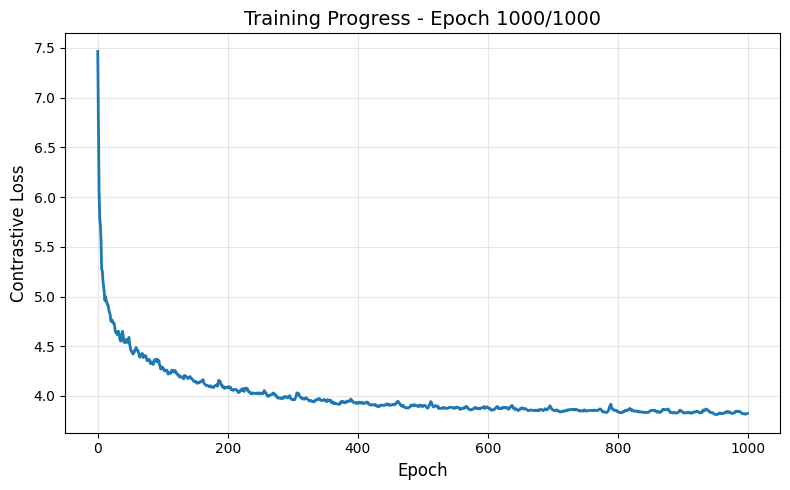

Epoch 1000/1000, Avg Loss: 3.8236

✓ Model saved to 'retrained_encoder.pt'
Final loss: 3.8236


In [ ]:
from pathlib import Path
from torch.utils.data import Dataset
from torch_geometric.data import Data
import torch
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt

##################################
# DATASET CLASS
##################################

class PointCloudGraphDataset(Dataset):
    """Dataset that loads point clouds as graphs"""
    
    def __init__(self, pcd_paths, k=16):
        self.pcd_paths = pcd_paths
        self.k = k
    
    def __len__(self):
        return len(self.pcd_paths)
    
    def __getitem__(self, idx):
        path = self.pcd_paths[idx]
        data = load_point_cloud_to_graph(str(path), k=self.k)
        return data


##################################
# LOAD DATASET
##################################

TRAIN_ROOT = Path("../training_data")
pcd_files = sorted(TRAIN_ROOT.glob("**/*.groundtruth.pcd"))
print(f"Found {len(pcd_files)} point clouds")

# Pre-load all data into memory (faster training)
print("Loading point clouds into memory...")
dataset = []
for i, pcd_file in enumerate(pcd_files):
    print(f"Loading {i+1}/{len(pcd_files)}: {pcd_file.name}")
    data = load_point_cloud_to_graph(str(pcd_file), k=16)
    dataset.append(data)

print(f"\n Dataset loaded: {len(dataset)} point clouds")


##################################
# GPU HELPER FUNCTIONS
##################################

def subsample_graph_gpu(data, num_nodes, k=16):
    """GPU-accelerated subsampling"""
    N = data.num_nodes
    idx = torch.randperm(N, device=data.pos.device)[:num_nodes]
    
    pos = data.pos[idx]
    x = data.x[idx]
    
    # GPU-based KNN
    dists = torch.cdist(pos, pos)
    knn = dists.topk(k=k+1, largest=False).indices[:, 1:]  # skip self
    row = torch.arange(num_nodes, device=pos.device).unsqueeze(1).repeat(1, k).flatten()
    col = knn.flatten()
    edge_index = torch.stack([row, col], dim=0)
    
    edge_attr = pos[row] - pos[col]
    
    return Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)


def augment_point_cloud(data, jitter=0.01):
    """Augment point cloud with jitter"""
    pos = data.pos + torch.randn_like(data.pos) * jitter
    x = torch.cat([pos, data.x[:, 3:]], dim=1)
    row, col = data.edge_index
    edge_attr = pos[row] - pos[col]
    return Data(
        x=x,
        pos=pos,
        edge_index=data.edge_index,
        edge_attr=edge_attr
    )


def contrastive_cosine_loss(z1, z2, temperature=0.5, batch_size_nodes=4096):
    """Computes contrastive loss between feature vectors"""
    N = z1.size(0)
    
    # Random subset of nodes (on same device)
    idx = torch.randperm(N, device=z1.device)[:batch_size_nodes]
    z1 = z1[idx]
    z2 = z2[idx]
    
    # Normalize features
    z1_norm = F.normalize(z1, dim=-1)
    z2_norm = F.normalize(z2, dim=-1)
    
    # Cosine similarity matrix
    sim_matrix = torch.matmul(z1_norm, z2_norm.T) / temperature
    positives = torch.diag(sim_matrix)
    
    # Denominator
    exp_sim = torch.exp(sim_matrix)
    denominator = exp_sim.sum(dim=1)
    
    # InfoNCE loss
    loss_per_point = -torch.log(torch.exp(positives) / denominator)
    return loss_per_point.mean()


##################################
# MODEL + OPTIMIZER
##################################

encoder = GNNEncoder(input_dim=6, hidden_dim=64, out_dim=32).to(device)
encoder.train()

optimizer = optim.Adam(encoder.parameters(), lr=1e-3)
scaler = torch.amp.GradScaler("cuda")

temperature = 0.2
max_epochs = 1000
batch_size_nodes = 4096

loss_history = []

print(f"Starting training on device: {device}")
print(f"Dataset size: {len(dataset)} point clouds")


##################################
# TRAINING LOOP
##################################

for epoch in range(1, max_epochs + 1):
    encoder.train()
    loss_epoch = 0.0
    
    for data in dataset:
        # Move entire graph to GPU
        data = data.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Subsample on GPU
        data_small = subsample_graph_gpu(data, num_nodes=4096)
        
        # Augment (stays on GPU)
        data1 = augment_point_cloud(data_small)
        data2 = augment_point_cloud(data_small)
        
        # Forward pass with mixed precision
        with torch.amp.autocast("cuda"):
            z1 = encoder(data1)
            z2 = encoder(data2)
            loss = contrastive_cosine_loss(
                z1, z2,
                temperature=temperature,
                batch_size_nodes=batch_size_nodes
            )
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loss_epoch += loss.item()
    
    # Average loss over dataset (OUTSIDE the data loop)
    loss_epoch /= len(dataset)
    loss_history.append(loss_epoch)
    
    # Live plotting - update every epoch
    clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Contrastive Loss", fontsize=12)
    plt.title(f"Training Progress - Epoch {epoch}/{max_epochs}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Epoch {epoch}/{max_epochs}, Avg Loss: {loss_epoch:.4f}")
    
    # Early stopping
    if loss_epoch < 0.3:
        print(f"\n Loss threshold reached ({loss_epoch:.4f} < 0.3), stopping training")
        break


##################################
# SAVE MODEL
##################################

torch.save(encoder.state_dict(), "retrained_encoder.pt")
print("\nModel saved to 'retrained_encoder.pt'")
print(f"Final loss: {loss_history[-1]:.4f}")

In [13]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F

# Recreate the model architecture (must match training)
encoder = GNNEncoder(input_dim=6, hidden_dim=64, out_dim=32)

# Load the trained weights
encoder.load_state_dict(torch.load("retrained_encoder.pt"))

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)

# Set to evaluation mode (important!)
encoder.eval()

print("Model loaded successfully!")

Model loaded successfully!


C:\Users\Xaglinath\AppData\Local\Temp\ipykernel_25096\1592207713.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("retrained_encoder.pt

In [27]:
import hdbscan
import numpy as np
import torch
import open3d as o3d
import matplotlib.pyplot as plt
from pathlib import Path
import time

##################################
# LOAD POINT CLOUD
##################################

print("=" * 60)
print("LOADING POINT CLOUD")
print("=" * 60)

pcd_path = "../extra_training/House2/0.living.obj.groundtruth.pcd"
pcd_path = str(Path(pcd_path)).replace('\x00', '').strip()

start = time.time()
data = load_point_cloud_to_graph(pcd_path, k=16)
# data = load_point_cloud_to_graph(o3d.data.PLYPointCloud().path)
print(f" Loaded in {time.time()-start:.2f}s")
print(f"  Points: {data.num_nodes:,}")

data = data.to(device)

##################################
# EXTRACT EMBEDDINGS
##################################

print("\n" + "=" * 60)
print("EXTRACTING EMBEDDINGS")
print("=" * 60)

encoder.eval()
start = time.time()
with torch.no_grad():
    z = encoder(data).cpu().numpy()
    pts = data.pos.cpu().numpy()

print(f" Extracted in {time.time()-start:.2f}s")
print(f"  Embeddings: {z.shape}")
print(f"  Positions: {pts.shape}")

# Combine features
features = np.concatenate([pts, z], axis=1)
print(f"  Combined features: {features.shape}")

##################################
# DOWNSAMPLE FOR FASTER CLUSTERING
##################################

# If point cloud is too large, subsample for clustering
MAX_POINTS = 50000  # Adjust based on your needs

if features.shape[0] > MAX_POINTS:
    print(f"\n⚠ Point cloud has {features.shape[0]:,} points")
    print(f"  Downsampling to {MAX_POINTS:,} for faster clustering...")
    
    idx = np.random.choice(features.shape[0], MAX_POINTS, replace=False)
    features_clustered = features[idx]
    pts_clustered = pts[idx]
    
    print(f" Using {features_clustered.shape[0]:,} points for clustering")
else:
    features_clustered = features
    pts_clustered = pts
    idx = np.arange(len(pts))

##################################
# HDBSCAN CLUSTERING (FASTER)
##################################

print("\n" + "=" * 60)
print("RUNNING HDBSCAN")
print("=" * 60)

start = time.time()
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,      # Increased for speed
    min_samples=25,            # Increased for speed
    metric='euclidean',
    core_dist_n_jobs=-1,       # Use all CPU cores
    algorithm='best'           # Let HDBSCAN choose fastest
)

print("Clustering... (this may take 30-60 seconds)")
labels = clusterer.fit_predict(features_clustered)

print(f" Clustered in {time.time()-start:.2f}s")

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_frac = np.mean(labels == -1)

print(f"\nResults:")
print(f"  Clusters: {n_clusters}")
print(f"  Noise: {noise_frac:.1%}")
print(f"  Clustered points: {(1-noise_frac)*100:.1f}%")

# Show cluster sizes
if n_clusters > 0:
    unique, counts = np.unique(labels[labels != -1], return_counts=True)
    print(f"\nCluster sizes:")
    for label, count in zip(unique, counts):
        print(f"  Cluster {label}: {count:,} points")

##################################
# VISUALIZATION
##################################

print("\n" + "=" * 60)
print("VISUALIZATION")
print("=" * 60)

unique_labels = np.unique(labels)
cluster_labels = unique_labels[unique_labels != -1]

if len(cluster_labels) == 0:
    print("\n⚠ NO CLUSTERS FOUND!")
    print("\nTry adjusting parameters:")
    print("  - min_cluster_size: lower = more clusters (try 50)")
    print("  - min_samples: lower = more sensitive (try 15)")
    
    # Visualize all points in gray
    print("\nShowing all points in gray...")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_clustered)
    pcd.paint_uniform_color([0.5, 0.5, 0.5])
    o3d.visualization.draw_geometries([pcd])
    
else:
    print(f"Generating colors for {len(cluster_labels)} clusters...")
    
    # Generate distinct colors
    cmap = plt.get_cmap("tab20")
    colors_map = np.array([cmap(i % 20)[:3] for i in range(len(cluster_labels))])
    label_to_color = {label: colors_map[i] for i, label in enumerate(cluster_labels)}
    
    # Assign colors (keep noise as black)
    colors_all = np.zeros((len(labels), 3))
    for i, L in enumerate(labels):
        if L != -1:
            colors_all[i] = label_to_color[L]
    
    print(f" Visualizing {len(pts_clustered):,} points")
    print("  Press Q to close visualization")
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_clustered)
    pcd.colors = o3d.utility.Vector3dVector(colors_all)
    
    # Add coordinate frame
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    
    # Visualize
    o3d.visualization.draw_geometries(
        [pcd, coord_frame],
        window_name=f"Clustered Point Cloud - {n_clusters} clusters",
        width=1280,
        height=720
    )

print("\n Done!")


LOADING POINT CLOUD
 Loaded in 2.78s
  Points: 196,133

EXTRACTING EMBEDDINGS
 Extracted in 0.32s
  Embeddings: (196133, 32)
  Positions: (196133, 3)
  Combined features: (196133, 35)

⚠ Point cloud has 196,133 points
  Downsampling to 50,000 for faster clustering...
 Using 50,000 points for clustering

RUNNING HDBSCAN
Clustering... (this may take 30-60 seconds)
 Clustered in 1.60s

Results:
  Clusters: 2
  Noise: 0.0%
  Clustered points: 100.0%

Cluster sizes:
  Cluster 0: 1,463 points
  Cluster 1: 48,524 points

VISUALIZATION
Generating colors for 2 clusters...
 Visualizing 50,000 points
  Press Q to close visualization

 Done!


In [39]:
pcd_path = "../extra_training/House2/0.living.obj.groundtruth.pcd"
pcd_path = str(Path(pcd_path)).replace('\x00', '').strip()

start = time.time()
load_point_cloud_to_graph(pcd_path, k=16)

None
